In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


### Reference: https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('/kaggle/input/riiid-test-answer-prediction')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   )

In [4]:
#reading in question df
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [5]:
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [6]:
print(f'We have {train.user_id.nunique()} unique users in our train set')

We have 393656 unique users in our train set


In [7]:
# Content_type_id = False means that a question was asked. True means that the user was watching a lecture.
train.content_type_id.value_counts()

0    99271300
1     1959032
Name: content_type_id, dtype: int64

In [8]:
print(f'We have {train.content_id.nunique()} content ids in our train set, of which {train[train.content_type_id == False].content_id.nunique()} are questions.')

We have 13782 content ids in our train set, of which 13523 are questions.


In [9]:
os.chdir('/kaggle/working')
from matplotlib.ticker import FuncFormatter

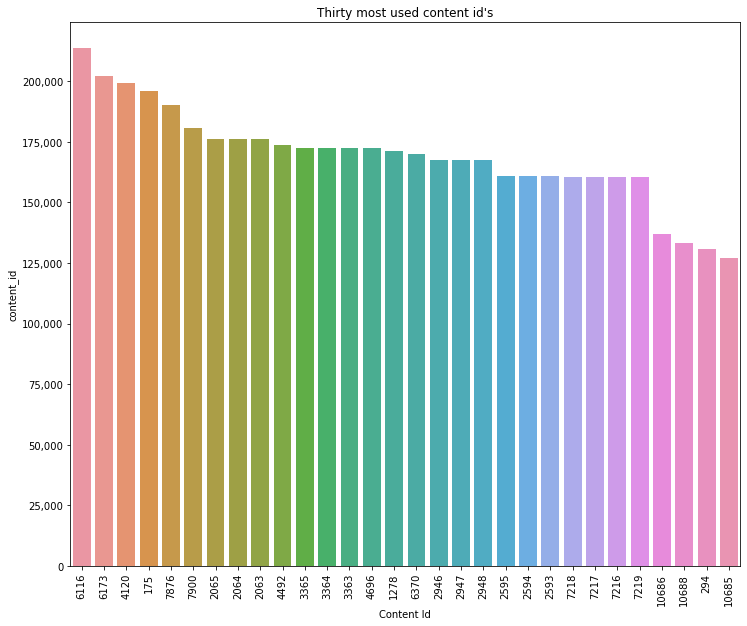

<Figure size 432x288 with 0 Axes>

In [10]:
cids = train.content_id.value_counts()[:30]
cids = cids.sort_values(ascending=False)
fig = plt.figure(figsize=(12,10))
ax = sns.barplot(x=cids.index, y=cids, order=cids.index)
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.xlabel('Content Id')
plt.show()
plt.savefig(fname = 'Thirty most used content id.jpg', dpi=300)

In [11]:
print(f'We have {train.task_container_id.nunique()} unique Batches of questions or lectures.')

We have 10000 unique Batches of questions or lectures.


In [12]:
# User answer. Seems that the questions are multiple choice (answers 0-3). As mentioned in the data description, -1 is actually no-answer (as the interaction was a lecture instead of a question).
train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

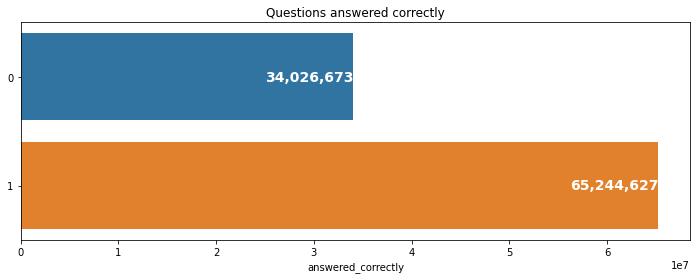

<Figure size 432x288 with 0 Axes>

In [13]:
# The target: answered_correctly
# Answered_correctly is our target, and we have to predict to probability for an answer to be correct. Without looking at the lecture interactions (-1), we see about 1/3 of the questions was answered incorrectly.
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
fig = plt.figure(figsize=(12,4))

ax = sns.barplot(x=correct, y=correct.index, orient='h')
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()
plt.savefig(fname = 'Questions answered correctly.jpg', dpi=300)

In [14]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')

the highest number of questions answered by a user is 17609


In [15]:
import matplotlib as mpl
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

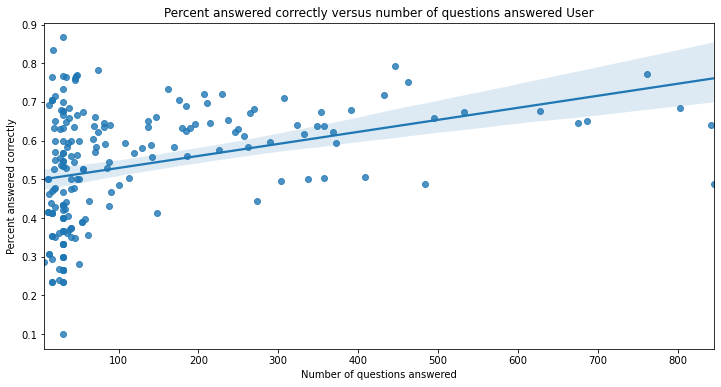

<Figure size 432x288 with 0 Axes>

In [16]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
ax = sns.regplot(x=x, y=y)
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
plt.show()
plt.savefig('Percent answered correctly vs number of questions answered user.jpg',dpi=300)

In [17]:
content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

The highest number of questions asked by content_id is 213605.
Of 13523 content_ids, 529 content_ids had more than 25,000 questions asked.


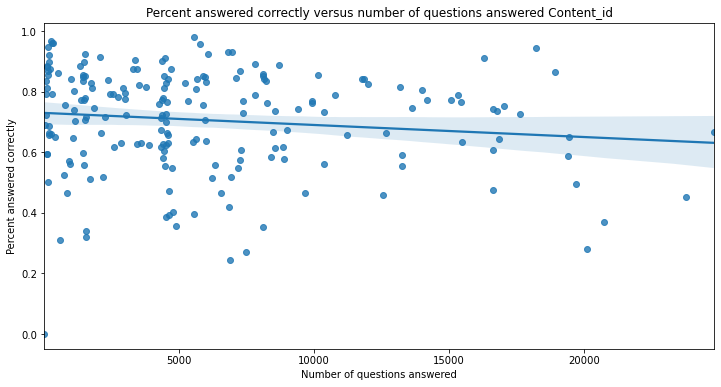

<Figure size 432x288 with 0 Axes>

In [18]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
ax = sns.regplot(x=x, y=y)
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

plt.show()
plt.savefig('Percent answered correctly vs number of questions answered Content_id.jpg',dpi=300)

prior_question_had_explanation
False     9193234
True     89685560
NaN        392506
Name: (answered_correctly, count), dtype: int64


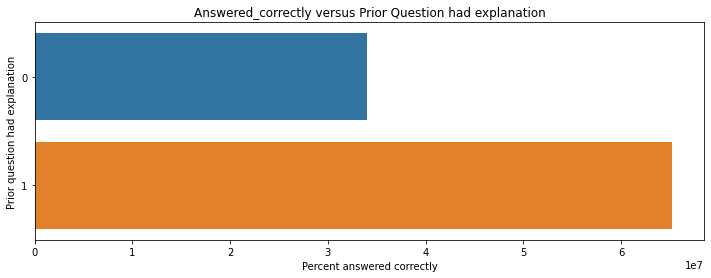

<Figure size 432x288 with 0 Axes>

In [19]:
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
ax = sns.barplot(x=correct, y=correct.index, orient='h')
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()
plt.savefig('Answered_correctly versus Prior Question had explanation.jpg',dpi=300)

In [20]:
tags_df = pd.DataFrame()
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

There are 188 different tags


,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


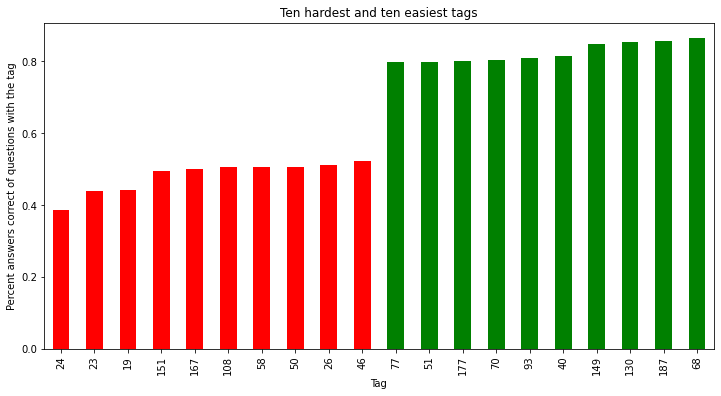

<Figure size 432x288 with 0 Axes>

In [21]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()
plt.savefig("Percent answers correct of questions with the tag,jpg", dpi = 300)

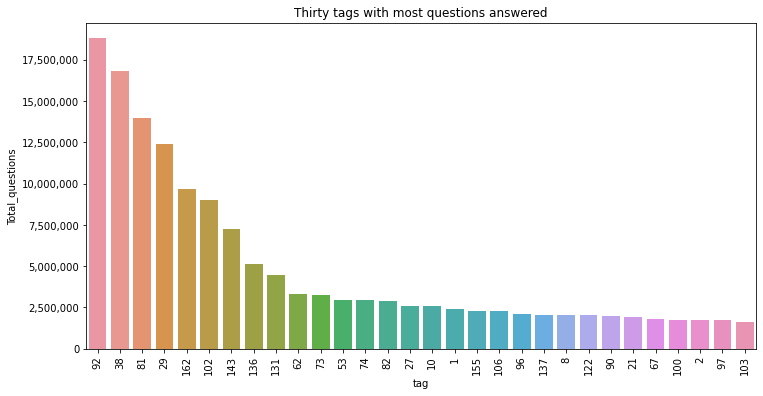

<Figure size 432x288 with 0 Axes>

In [22]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]
fig = plt.figure(figsize=(12,6))
ax = sns.barplot(x=tags_select.index, y=tags_select, order=tags_select.index)
plt.title("Thirty tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()
plt.savefig('Thirty tags with most questions answered.jpg',dpi=300)

### Check whether watch lectures would help or not

False    244050
True     149606
Name: Watches_lecture, dtype: int64


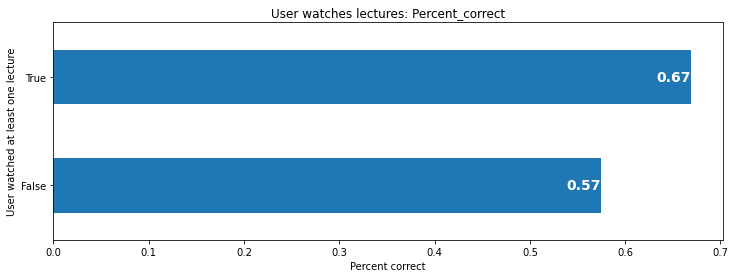

<Figure size 432x288 with 0 Axes>

In [23]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()
plt.savefig('User watches lectuers vs percent correct.jpg',dpi=300)